In [47]:
import numpy as np
import torch
import torch.nn as nn
import models.capsule_argmax
import torchvision
from torchvision import transforms, datasets
from torch.distributions import normal
import matplotlib.pyplot as plt
import captum
from captum.attr import DeepLift, IntegratedGradients, Saliency, NoiseTunnel, GradientShap
from captum.attr import visualization as viz
import argparse
from utils import get_args
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [48]:
torch.cuda.set_device(1)

In [49]:
def add_gaussian_noise(noise_scale, input):
    noise = torch.randn_like(input) * noise_scale
    return input + noise

def predict_with_randomized_smoothing(noise_scale, model, image, num_samples):
    # Expand the single image to a batch
    image_batch = image.repeat(num_samples, 1, 1, 1)
    # Add Gaussian noise
    noisy_images = add_gaussian_noise(noise_scale, image_batch)

    # Predict using the model
    predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model(noisy_images)

    # Get the predicted classes for each noisy image
    _, predicted_classes = predictions.max(1)
    #Result
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    # Return the most frequently predicted class
    return avg_noisy_image, predictions, predicted_classes, prediction

def show_image(input, noise_scale):
    fig, axes = plt.subplots(1, len(noise_scale), figsize=(20, 10))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for idx, noise in enumerate(noise_scale):
        avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise, global_model, input, 100)
        print(f'Noise: {noise}, Ground Truth: {ground_truth_prediction}, Noised Result: {prediction}')
        img = avg_noisy_image.squeeze().cpu().detach().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        ax = axes[idx]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'noise_scale:{noise}')
    plt.tight_layout()
    plt.show()

Files already downloaded and verified
Files already downloaded and verified
Noise: 0, Ground Truth: 6, Noised Result: 6
Noise: 0.5, Ground Truth: 6, Noised Result: 6
Noise: 1, Ground Truth: 6, Noised Result: 6
Noise: 1.5, Ground Truth: 6, Noised Result: 9
Noise: 2.0, Ground Truth: 6, Noised Result: 9
Noise: 2.5, Ground Truth: 6, Noised Result: 1
Noise: 3.0, Ground Truth: 6, Noised Result: 9
Noise: 3.5, Ground Truth: 6, Noised Result: 9
Noise: 4.0, Ground Truth: 6, Noised Result: 9
Noise: 4.5, Ground Truth: 6, Noised Result: 9
Noise: 5.0, Ground Truth: 6, Noised Result: 9


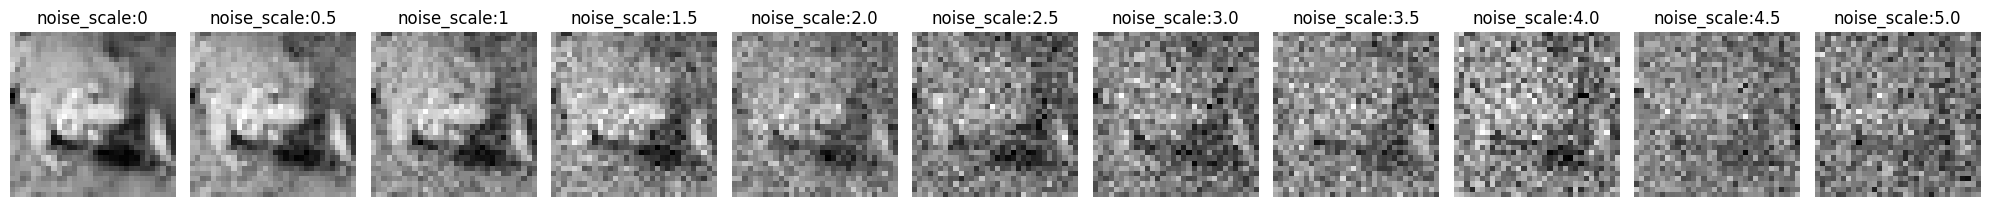

In [50]:
args = get_args.get_arg()
data_dir = './data/cifar'
sigma = 0.5
apply_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.CIFAR10(data_dir, train=True, download=True, transform=apply_transform)
test_dataset = datasets.CIFAR10(data_dir, train=False, download=True, transform=apply_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)
device = 'cuda'
global_model = models.capsule_argmax.CapsNet(device=device)
state_dict = torch.load(f'./checkpoints/Capsule/cifar/common_units32/best_model_cifar.pth')
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
global_model.load_state_dict(new_state_dict)
global_model.to(device)
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
classes = ('airplane', 'automobile', 'brid', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

ind = 5
input = images[ind].unsqueeze(0)
input.requires_grad = True
global_model.eval()
ground_truth_predictions, reconstruction, primary_caps_output, digit_caps_output, c, b= global_model(input)
_, predicted_classes = ground_truth_predictions.max(1)
ground_truth_prediction = torch.bincount(predicted_classes).argmax().item()
noise_scale = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0 ,3.5, 4.0, 4.5, 5.0]
show_image(input, noise_scale)

In [51]:
def test_capsule(model, device, test_loader):
    model.eval()
    correct, total = 0, 0
    for images, labels in test_loader:
        # Add channels = 1
        images = images.to(device)
        # Categogrical encoding
        labels = torch.eye(10).index_select(dim=0, index=labels).to(device)
        logits, reconstructions, primary_caps_output, digit_caps_output, c, b = model(images)
        pred_labels = torch.argmax(logits, dim=1)
        correct += torch.sum(pred_labels == torch.argmax(labels, dim=1)).item()
        total += len(labels)

    print('Accuracy: {}'.format(correct / total))

In [52]:
test_capsule(global_model, device, test_loader)

Accuracy: 0.7474


In [53]:
index_new = 5 # 28 18 10 13 15 16 19 9 7 8

In [54]:
def visualize_capsule_soft(noise_scale, model, input, num_samples, name):
    image = images[input].unsqueeze(0)
    image_batch = image.repeat(num_samples, 1, 1, 1)
    noisy_images = add_gaussian_noise(noise_scale, image_batch)
    predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model(noisy_images)
    c = c.cpu()
    c_mean = c.mean(dim=0).squeeze(-1)
    c_mean = c_mean.T
    plt.imshow(c_mean, cmap='hot', aspect='auto') 
    plt.xlabel('Vote Option')
    plt.ylabel('Primary Capsule Number')
    plt.title('Heatmap of Soft Voting Results')
    plt.savefig(name)
    plt.show()
def visualize_capsule_hard(noise_scale, model, input, num_samples, name):
    image = images[input].unsqueeze(0)
    image_batch = image.repeat(num_samples, 1, 1, 1)
    noisy_images = add_gaussian_noise(noise_scale, image_batch)
    predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model.argmax_forward(noisy_images)
    c = c.cpu()
    one_hot = torch.zeros(c.size(0), c.size(1), c.size(2), 10)
    one_hot.scatter_(-1, c.long(), 1)
    vote_freqs = one_hot.sum(dim=0).squeeze(0) / c.size(0)
    plt.imshow(vote_freqs, cmap='hot', aspect='auto')  
    plt.ylabel('Primary Capsule Number')  
    plt.xlabel('Vote Option') 
    plt.title('Heatmap of Hard Voting Results')
    plt.savefig(name)
    plt.show()

In [55]:
def visualize_capsule_soft_change(noise_scale, model, images, input, num_samples, name1, name2):
    image = images[input].unsqueeze(0)
    image_batch = image.repeat(num_samples, 1, 1, 1)
    noisy_images_baseline = add_gaussian_noise(0, image_batch) 
    predictions_baseline, reconstruction_baseline, primary_caps_output_baseline, digit_caps_output_baseline, c_baseline, b_baseline = model(noisy_images_baseline)
    predictions2_baseline, reconstruction2_baseline, primary_caps_output2_baseline, digit_caps_output2_baseline, c2_baseline, b2_baseline = model.argmax_forward(noisy_images_baseline)
    c_baseline = c_baseline.cpu()
    c_baseline_mean = c_baseline.mean(dim=0).squeeze(-1)
    c_baseline_mean = c_baseline_mean.T
    c2_baseline = c2_baseline.cpu()
    one_hot_baseline = torch.zeros(c2_baseline.size(0), c2_baseline.size(1), c2_baseline.size(2), 10)
    one_hot_baseline.scatter_(-1, c2_baseline.long(), 1)
    vote_freqs_baseline = one_hot_baseline.sum(dim=0).squeeze(0) / c2_baseline.size(0)
    
    noisy_images = add_gaussian_noise(noise_scale, image_batch) 
    predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model(noisy_images)
    predictions2, reconstruction2, primary_caps_output2, digit_caps_output2, c2, b2 = model.argmax_forward(noisy_images)
    
    c = c.cpu()
    c_mean = c.mean(dim=0).squeeze(-1)
    c_mean = c_mean.T

    plt.imshow(c_mean, cmap='hot', aspect='auto') 
    plt.xlabel('Vote Option')
    plt.ylabel('Primary Capsule Number')
    plt.title('Heatmap of Soft Voting Results')
    plt.savefig(name1)
    plt.show()
    
    c_mean_change = c_mean - c_baseline_mean
    c_mean_change = c_mean_change.abs().sum(dim=1)
    c_mean_change = c_mean_change.mean()
    change_rate_soft = float(c_mean_change) * 100
    print('Change rate of Soft Voting:', change_rate_soft, '%')
    
    c2 = c2.cpu()
    one_hot = torch.zeros(c2.size(0), c2.size(1), c2.size(2), 10)
    one_hot.scatter_(-1, c2.long(), 1)
    vote_freqs = one_hot.sum(dim=0).squeeze(0) / c2.size(0)
    
    plt.imshow(vote_freqs, cmap='hot', aspect='auto')  
    plt.xlabel('Vote Option') 
    plt.ylabel('Primary Capsule Number')  
    plt.title('Heatmap of Hard Voting Results')
    plt.savefig(name2)
    plt.show()

    c2_mean_change = vote_freqs - vote_freqs_baseline
    c2_mean_change = c2_mean_change.abs().sum(dim=1)
    c2_mean_change = c2_mean_change.mean()
    change_rate_hard = float(c2_mean_change) * 100
    print('Change rate of Hard Voting:', change_rate_hard, '%')
    

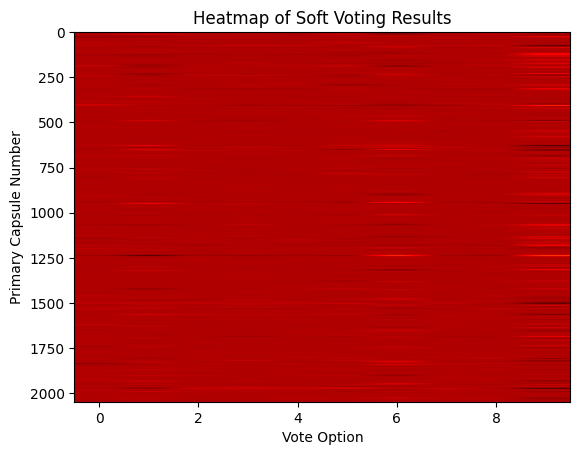

Change rate of Soft Voting: 1.033913902938366 %


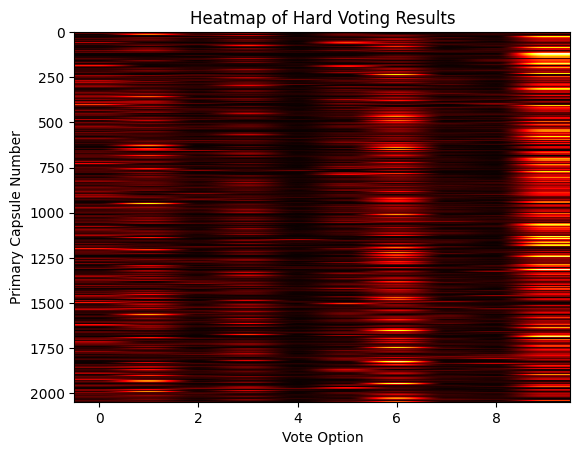

Change rate of Hard Voting: 170.77441215515137 %


In [40]:
name1 = 'ChangeRate_Soft'
name2 = 'ChangeRate_Hard'
visualize_capsule_soft_change(1.5, global_model, images, index_new, 100, name1, name2)

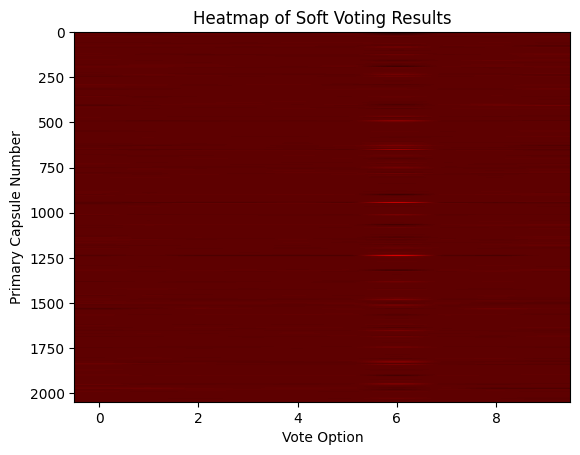

Change rate of Soft Voting: 0.7601330056786537 %


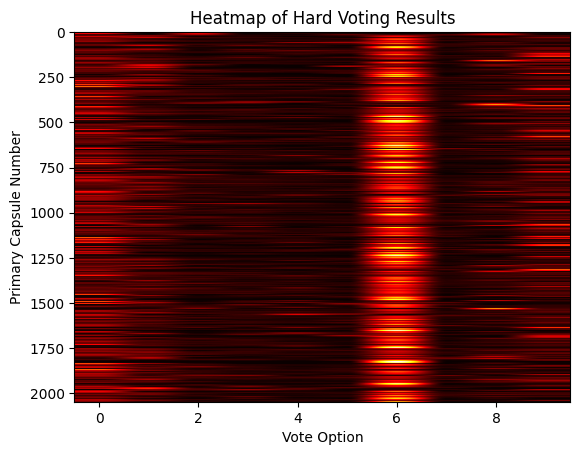

Change rate of Hard Voting: 149.00782108306885 %


In [44]:
name1 = 'ChangeRate_Soft_05'
name2 = 'ChangeRate_Hard_05'
visualize_capsule_soft_change(0.5, global_model, images, index_new, 100, name1, name2)

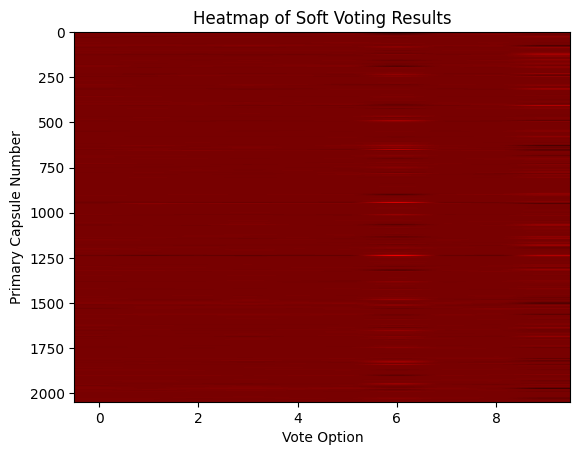

Change rate of Soft Voting: 0.8544477634131908 %


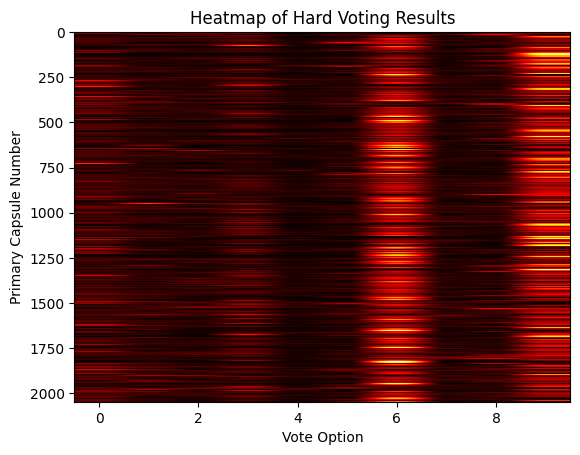

Change rate of Hard Voting: 162.51952648162842 %


In [45]:
name1 = 'ChangeRate_Soft_10'
name2 = 'ChangeRate_Hard_10'
visualize_capsule_soft_change(1.0, global_model, images, index_new, 100, name1, name2)

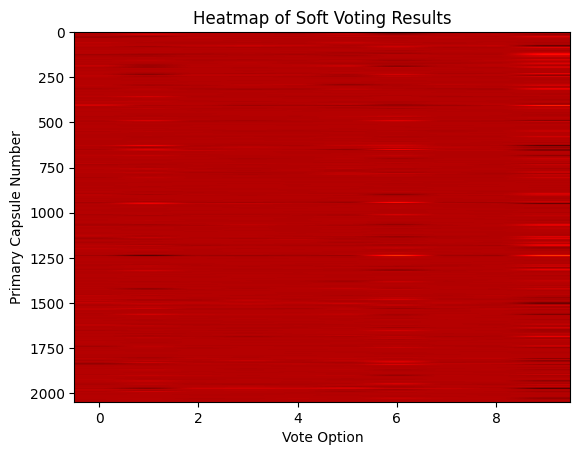

Change rate of Soft Voting: 1.0677398182451725 %


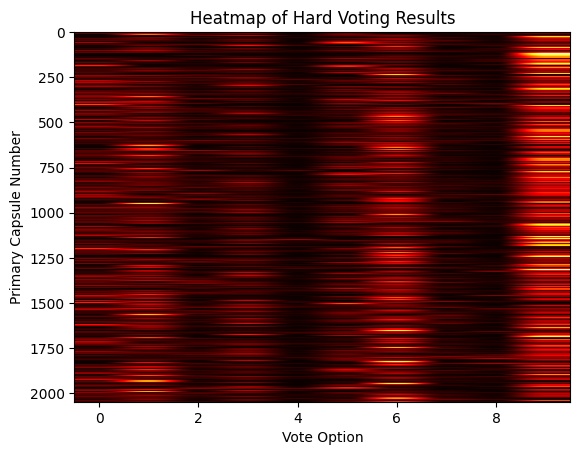

Change rate of Hard Voting: 171.45603895187378 %


In [46]:
name1 = 'ChangeRate_Soft_15'
name2 = 'ChangeRate_Hard_15'
visualize_capsule_soft_change(1.5, global_model, images, index_new, 100, name1, name2)

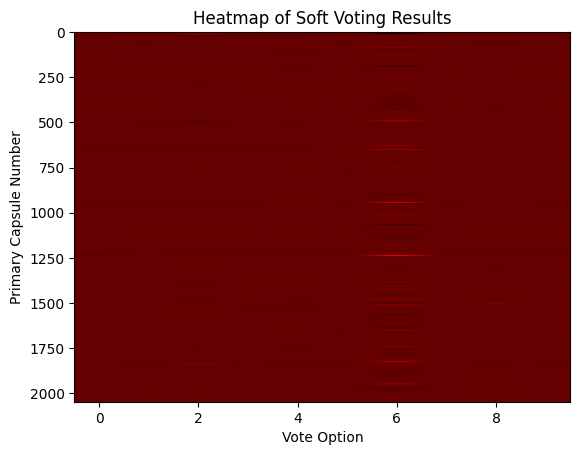

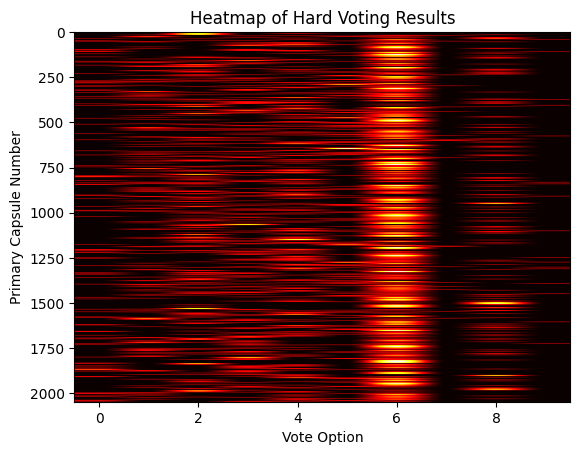

In [15]:
name1 = 'Soft_HeatMap_Noise_0.jpg'
name2 = 'Hard_HeatMap_Noise_0.jpg'
visualize_capsule_soft(0, global_model, index_new, 100, name1)
visualize_capsule_hard(0, global_model, index_new, 100, name2)

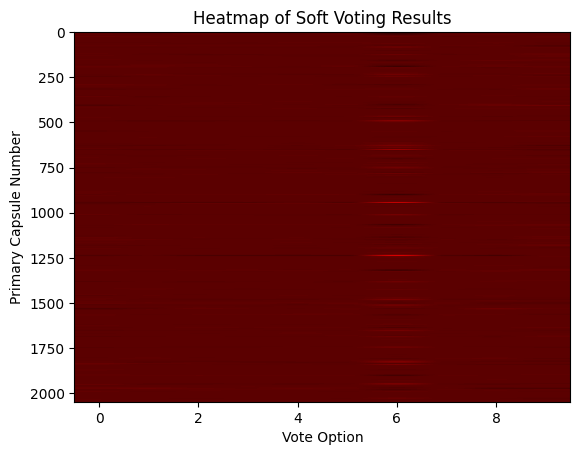

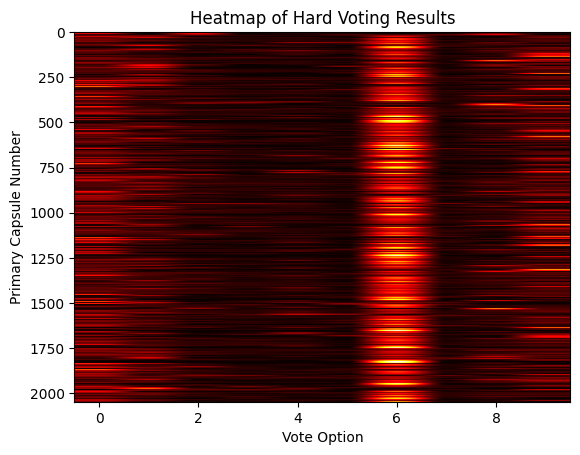

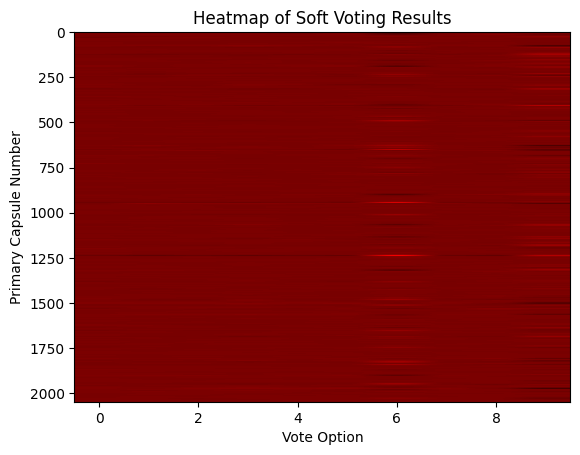

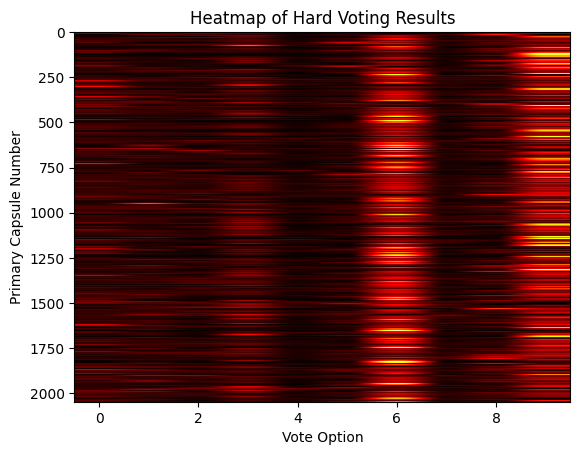

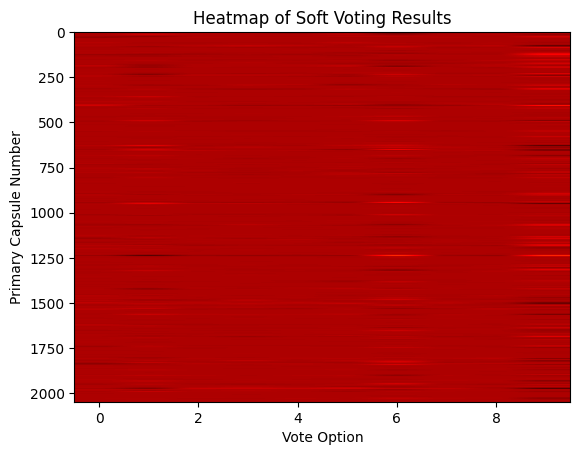

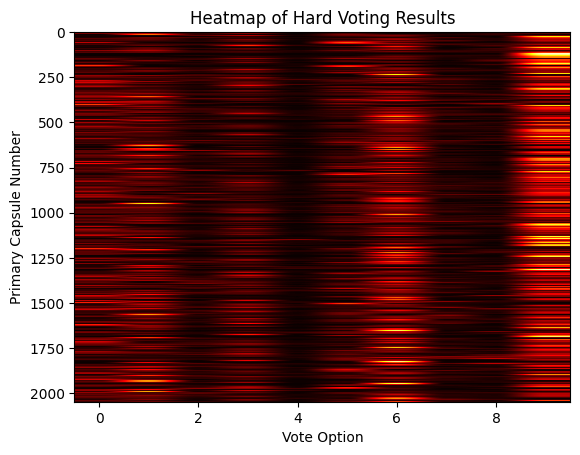

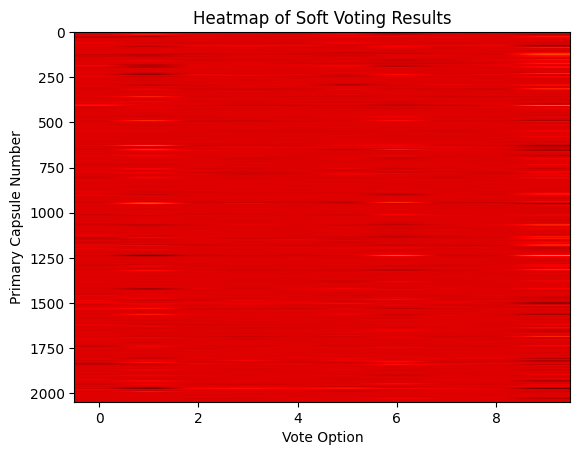

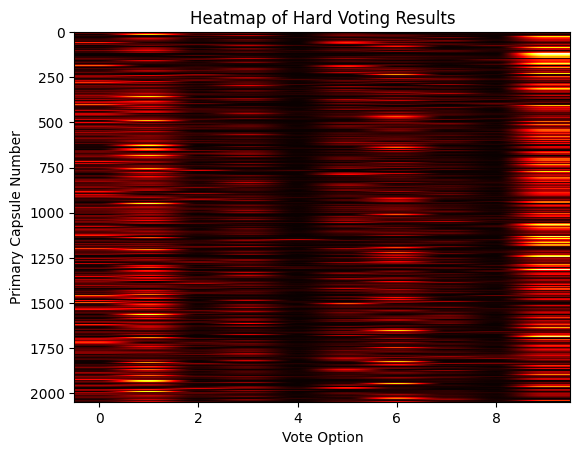

In [16]:
name1 = 'Soft_HeatMap_Noise_0.5.jpg'
name2 = 'Hard_HeatMap_Noise_0.5.jpg'
visualize_capsule_soft(0.5, global_model, index_new, 100, name1)
visualize_capsule_hard(0.5, global_model, index_new, 100, name2)
name1 = 'Soft_HeatMap_Noise_1.0.jpg'
name2 = 'Hard_HeatMap_Noise_1.0.jpg'
visualize_capsule_soft(1.0, global_model, index_new, 100, name1)
visualize_capsule_hard(1.0, global_model, index_new, 100, name2)
name1 = 'Soft_HeatMap_Noise_1.5.jpg'
name2 = 'Hard_HeatMap_Noise_1.5.jpg'
visualize_capsule_soft(1.5, global_model, index_new, 100, name1)
visualize_capsule_hard(1.5, global_model, index_new, 100, name2)
name1 = 'Soft_HeatMap_Noise_2.0.jpg'
name2 = 'Hard_HeatMap_Noise_2.0.jpg'
visualize_capsule_soft(2.0, global_model, index_new, 100, name1)
visualize_capsule_hard(2.0, global_model, index_new, 100, name2)

In [68]:
def visualize_capsule_soft_and_hard(noise_scale, model, images, input, num_samples, name1, name2):
    color = 'yellow'
    
    image = images[input].unsqueeze(0)
    image_batch = image.repeat(num_samples, 1, 1, 1)
    noisy_images = add_gaussian_noise(noise_scale, image_batch) 
    selected_index = torch.randperm(2048)[:4]
    
    predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model(noisy_images)
    c = c.cpu()
    c_mean = c.mean(dim=0).squeeze(-1)
    c_mean = c_mean.T
    fig, ax = plt.subplots()
    cax = ax.imshow(c_mean, cmap='hot', aspect='auto')
    ax.set_xlabel('Vote Option')
    ax.set_ylabel('Primary Capsule Number')
    ax.set_title('Heatmap of Soft Voting Results')
    axins = inset_axes(ax, width="60%", height="60%", loc='lower left',
                       bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    axins.imshow(c_mean, cmap='hot', aspect='auto', extent=[0, c_mean.shape[1], 0, c_mean.shape[0]])
    axins.set_xlim(5.5, 6.5)  
    axins.set_ylim(1200, 1300) 
    axins.set_xticklabels('')  
    axins.set_yticklabels('') 
    # print(c_mean.size())
    # print(c_mean)
    mark_inset(ax, axins, loc1=3, loc2=2, fc="none", ec=color)
    plt.savefig(name1)
    plt.show()
    # if noise_scale != 0:
    #     noisy_images_baseline = add_gaussian_noise(0, image_batch) 
    #     predictions, reconstruction, primary_caps_output, digit_caps_output, c_baseline, b = model(noisy_images)
    #     c_baseline = c_baseline.cpu()
    #     c_baseline_mean = c_baseline.mean(dim=0).squeeze(-1)
    #     c_baseline_mean = c_baseline_mean.T
    #     soft_change_rate = []
    #     for i in selected_index:
    #         soft_change_rate.append((torch.norm(c_mean[i, :] - c_baseline_mean[i, :]) / torch.norm(c_baseline_mean[i, :])) * 100)
    #     print('Four randomly selected primary capsules\' Change Rates compared to noise-free condition: ')
    #     print(soft_change_rate)
    predictions2, reconstruction2, primary_caps_output2, digit_caps_output, c2, b2 = model.argmax_forward(noisy_images)
    c2 = c2.cpu()
    c2_flat = c2.squeeze().T
    modes, _ = c2_flat.mode(dim=1)
    modes = modes.to(torch.long)
    one_hot2 = torch.nn.functional.one_hot(modes, num_classes=10)
    fig2, ax2 = plt.subplots()
    cax2 = ax2.imshow(one_hot2, cmap='hot', aspect='auto')
    ax2.set_xlabel('Vote Options')
    ax2.set_ylabel('Primary Capsule Number')
    ax2.set_title('Heatmap of Hard Voting Results')
    axins2 = inset_axes(ax2, width="60%", height="60%", loc='lower left',
                       bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax.transAxes, borderpad=0)
    axins2.imshow(one_hot2, cmap='hot', aspect='auto', extent=[0, one_hot2.shape[1], 0, one_hot2.shape[0]])
    axins2.set_xlim(5.5, 6.5)
    axins2.set_ylim(1200, 1300)
    axins2.set_xticklabels('')
    axins2.set_yticklabels('')
    mark_inset(ax2, axins2, loc1=3, loc2=2, fc="none", ec=color)
    plt.savefig(name2)
    plt.show()
    # if noise_scale != 0:
    #     noisy_images_baseline = add_gaussian_noise(0, image_batch) 
    #     predictions2, reconstruction2, primary_caps_output2, digit_caps_output, c2_baseline, b2 = model.argmax_forward(noisy_images)
    #     c2_baseline = c2_baseline.cpu()
    #     c2_baseline_flat = c2_baseline.squeeze().T
    #     modes_baseline, _ = c2_baseline_flat.mode(dim=1)
    #     modes_baseline = modes_baseline.to(torch.long)
    #     one_hot2_baseline = torch.nn.functional.one_hot(modes_baseline, num_classes=10)
    #     hard_change_rate = []
    #     for i in selected_index:
    #         hard_change_rate.append((torch.norm(one_hot2[i, :] - one_hot2_baseline[i, :]) / torch.norm(one_hot2_baseline[i, :])) * 100)
    #     print('Four randomly selected primary capsules\' Change Rates compared to noise-free condition: ')
    #     print(hard_change_rate)

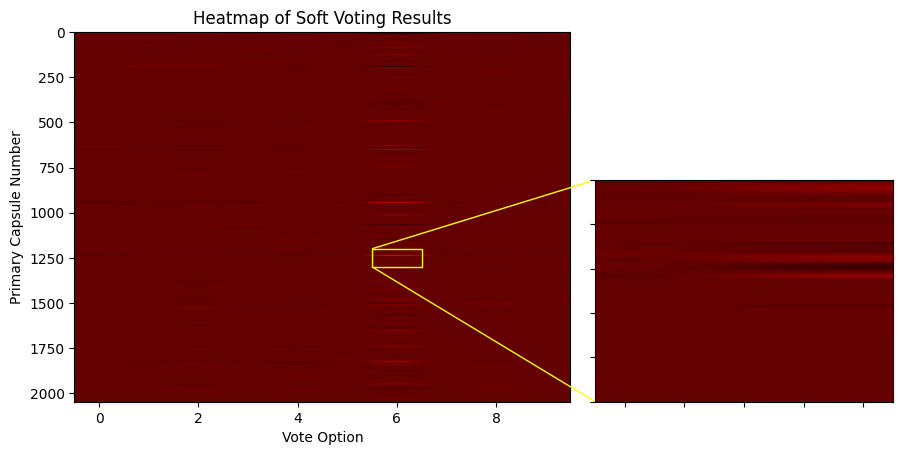

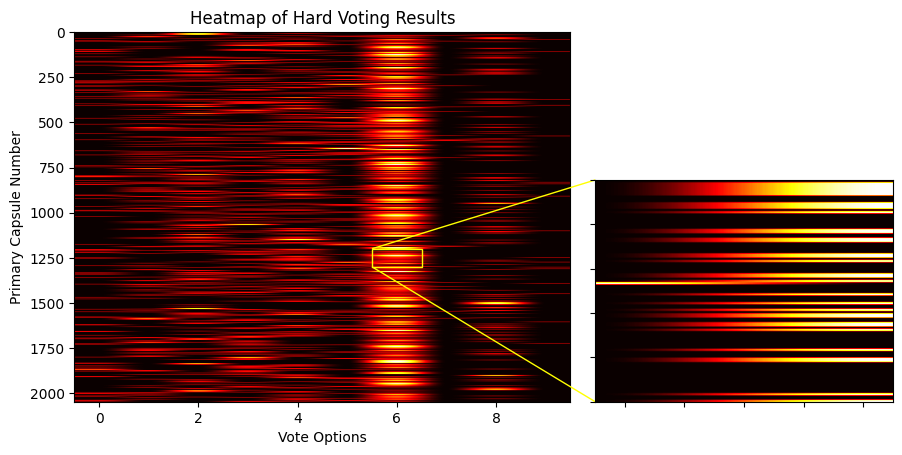

In [69]:
name1 = 'Soft_HeatMap_Noise_0.jpg'
name2 = 'Hard_HeatMap_Noise_0.jpg'
visualize_capsule_soft_and_hard(0, global_model, images, index_new, 100, name1, name2)

In [ ]:
name1 = 'Soft_HeatMap_Noise_0.5.jpg'
name2 = 'Hard_HeatMap_Noise_0.5.jpg'
visualize_capsule_soft_and_hard(0.5, global_model, images, index_new, 100, name1, name2)
name1 = 'Soft_HeatMap_Noise_1.0.jpg'
name2 = 'Hard_HeatMap_Noise_1.0.jpg'
visualize_capsule_soft_and_hard(1.0, global_model, images, index_new, 100, name1, name2)
name1 = 'Soft_HeatMap_Noise_1.5.jpg'
name2 = 'Hard_HeatMap_Noise_1.5.jpg'
visualize_capsule_soft_and_hard(1.5, global_model, images, index_new, 100, name1, name2)
name1 = 'Soft_HeatMap_Noise_2.0.jpg'
name2 = 'Hard_HeatMap_Noise_2.0.jpg'
visualize_capsule_soft_and_hard(2.0, global_model, images, index_new, 100, name1, name2)

In [ ]:
# def visual_images2(model, index):
#     input = images[index].unsqueeze(0)
#     label = labels[index]
#     input.requires_grad = True
#     model.eval()
#     ground_truth_predictions, reconstruction , primary_caps_output, digit_caps_output, c, b= model(input)
#     _, predicted_class_index = torch.max(ground_truth_predictions, 1)
#     print('--------------------')
#     # print(f'The size of primary caps is {primary_caps_output.size()}')
#     # print(f'The size of digit caps is {digit_caps_output.size()}')
#     print('--------------------')
#     print(f'The size of c is {c.size()}')
#     print(f'The size of b is {b.size()}')
#     print(f'c_max is {c[0][5]}')
#     # print(f'c is {c}')
#     return primary_caps_output, digit_caps_output, c, b

# def visualize_digit_caps_output(digit_caps_output):
#     caps_sizes = np.linalg.norm(digit_caps_output.squeeze().cpu().detach().numpy(), axis=1)
#     plt.bar(range(len(caps_sizes)), caps_sizes)
#     plt.xlabel('Capsule')
#     plt.ylabel('Number of Votes')
#     plt.title('Capsule Distribution')
#     plt.show()

# def visualize_digit_caps_output_smoothing_softmax(noise_scale, model, input, num_samples):
#     image = images[input].unsqueeze(0)
#     image_batch = image.repeat(num_samples, 1, 1, 1)
#     noisy_images = add_gaussian_noise(noise_scale, image_batch)
#     predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model(noisy_images)
#     _, predicted_classes = predictions.max(1)
#     avg_noisy_image = noisy_images.mean(0, keepdim=True)
#     prediction = torch.bincount(predicted_classes).argmax().item()
#     average_digit_caps_output = digit_caps_output.mean(dim=0, keepdim=True)
#     c_int = torch.argmax(c, dim=1)
#     c_int = c_int.view(-1)
#     index_counts = torch.bincount(c_int, minlength=10)
#     caps_sizes = index_counts / index_counts.sum()
#     caps_sizes = caps_sizes.cpu().numpy()
#     plt.bar(range(len(caps_sizes)), caps_sizes)
#     plt.xlabel('Capsule')
#     plt.ylabel('Number of Votes')
#     plt.title('Capsule Distribution')
#     plt.show()

# def visualize_digit_caps_output_smoothing(noise_scale, model, input, num_samples):
#     image = images[input].unsqueeze(0)
#     image_batch = image.repeat(num_samples, 1, 1, 1)
#     noisy_images = add_gaussian_noise(noise_scale, image_batch)
#     predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model.argmax_forward(noisy_images)
#     _, predicted_classes = predictions.max(1)
#     avg_noisy_image = noisy_images.mean(0, keepdim=True)
#     prediction = torch.bincount(predicted_classes).argmax().item()
#     average_digit_caps_output = digit_caps_output.mean(dim=0, keepdim=True)
#     # print(digit_caps_output)
#     # print(average_digit_caps_output)
#     # print(c)
#     c_flat = c.view(-1)
#     index_counts = torch.bincount(c_flat, minlength=10)
#     caps_sizes = index_counts / index_counts.sum()
#     caps_sizes = caps_sizes.cpu().numpy()
#     # caps_sizes = np.linalg.norm(average_digit_caps_output.squeeze().cpu().detach().numpy(), axis=1)
#     # print(caps_sizes)
#     plt.bar(range(len(caps_sizes)), caps_sizes)
#     plt.xlabel('Capsule')
#     plt.ylabel('Number of Votes')
#     plt.title('Capsule Distribution')
#     plt.show()

In [14]:
selected_index = torch.randperm(2048)[:4]

In [15]:
selected_index

tensor([ 335, 2032,  502, 1644])

In [20]:
def visualize_capsule_shift(model, input, num_samples):
    noise_list = [0.0, 0.5, 1.0, 1.5]
    image = images[input].unsqueeze(0)
    image_batch = image.repeat(num_samples, 1, 1, 1)
    c_mean_baseline = None
    one_hot2_baseline = None
    c_mean_change_rates = torch.zeros(len(noise_list), 10)
    one_hot2_change_rates = torch.zeros(len(noise_list), 10)
    for i, noise_level in enumerate(noise_list):
        noisy_images = add_gaussian_noise(noise_level, image_batch)
        predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model(noisy_images)
        c = c.cpu()
        c_mean = c.mean(dim=0).squeeze(-1).T
        # print(c_mean)
        predictions2, reconstruction2, primary_caps_output2, digit_caps_output, c2, b2 = model.argmax_forward(noisy_images)
        c2 = c2.cpu()
        c2_flat = c2.squeeze().T
        modes, _ = c2_flat.mode(dim=1)
        modes = modes.to(torch.long)
        one_hot2 = torch.nn.functional.one_hot(modes, num_classes=10).float()
        # print(one_hot2)
        if noise_level == 0.0:
            c_mean_baseline = c_mean
            one_hot2_baseline = one_hot2
        else:
            for j in range(10): 
                c_mean_change_rates[i, j] = (torch.norm(c_mean[:, j] - c_mean_baseline[:, j]) / torch.norm(c_mean_baseline[:, j])) * 100
                one_hot2_change_rates[i, j] = (torch.norm(one_hot2[:, j] - one_hot2_baseline[:, j]) / torch.norm(one_hot2_baseline[:, j])) * 100

In [21]:
c_mean_change_rates, one_hot2_change_rates = visualize_capsule_shift(global_model, index_new, 100)

In [22]:
c_mean_change_rates #soft voting

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [1.6261, 1.2421, 0.9708, 0.8988, 0.9124, 1.0924, 3.5947, 0.6410, 2.0455,
         1.8220],
        [0.8909, 1.0264, 1.2262, 1.0646, 1.1795, 1.1051, 2.6443, 0.7179, 1.6417,
         4.2488],
        [1.2965, 2.9115, 1.2932, 1.2473, 1.2483, 1.6488, 3.4297, 0.9809, 1.5053,
         4.9096]])

In [23]:
one_hot2_change_rates #hard voting

tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000],
        [197.1739, 137.6991, 104.8379, 106.4121, 102.5978, 105.4093,  98.3214,
         131.7893, 125.7656, 359.7385],
        [149.1472, 111.0750, 109.4622, 122.6744, 100.6055, 116.3160,  98.6464,
         158.9439, 124.7219, 630.5927],
        [161.9398, 157.0838, 109.0499, 127.7636, 100.8065, 131.1089,  97.9953,
         176.2176, 111.1438, 639.8529]])

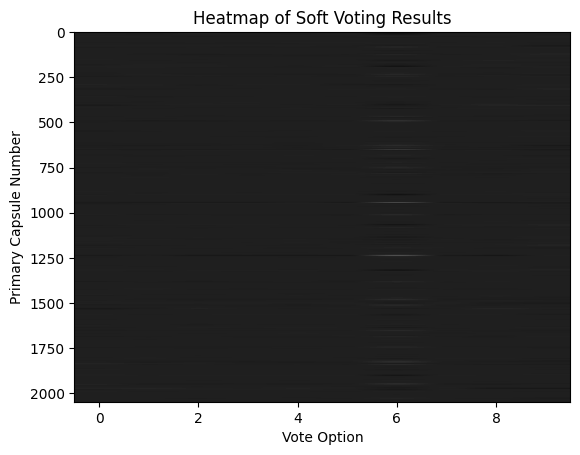

c_size is  torch.Size([100, 1, 2048, 1])


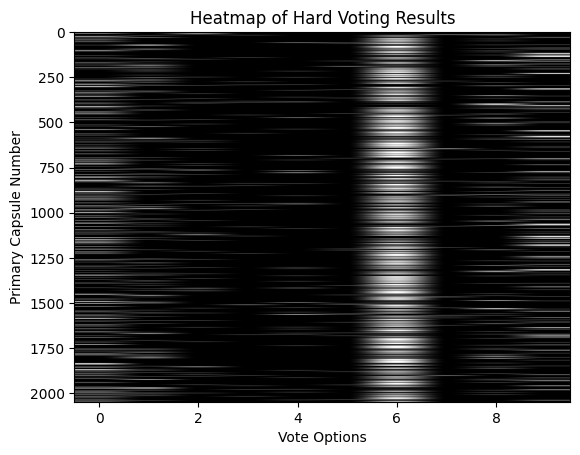

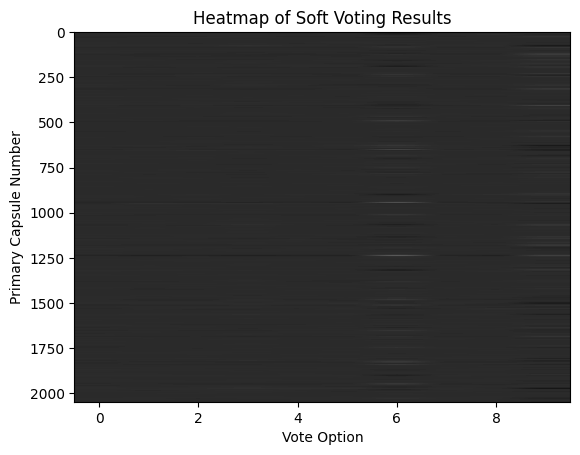

c_size is  torch.Size([100, 1, 2048, 1])


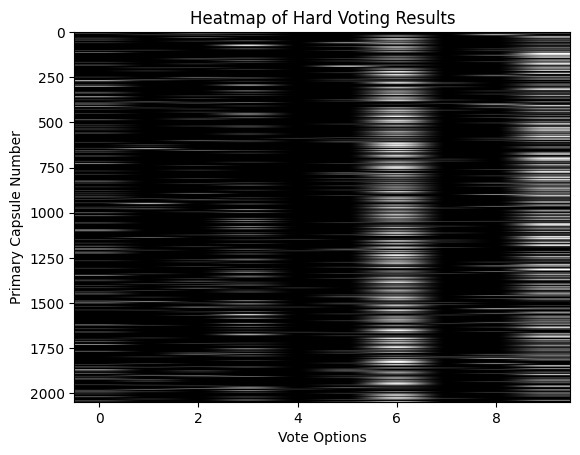

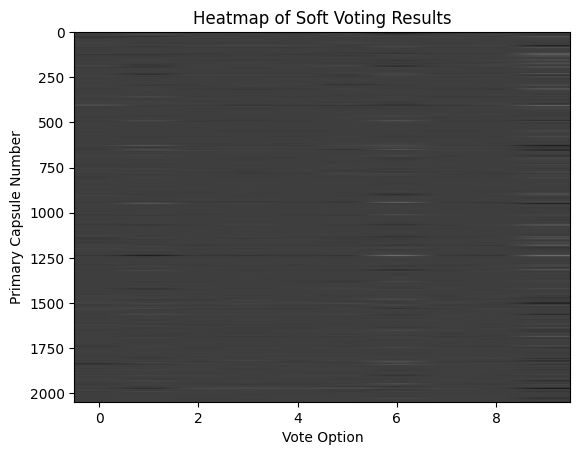

c_size is  torch.Size([100, 1, 2048, 1])


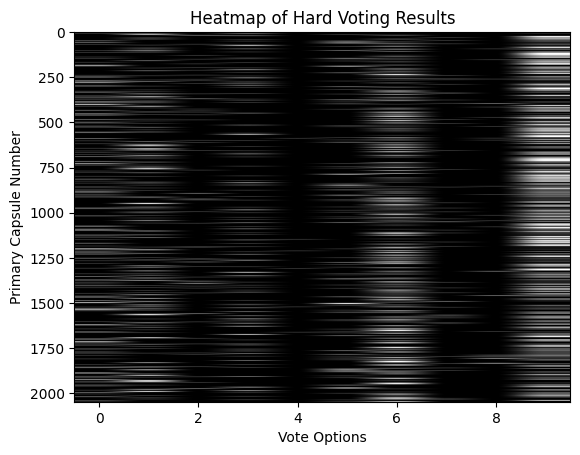

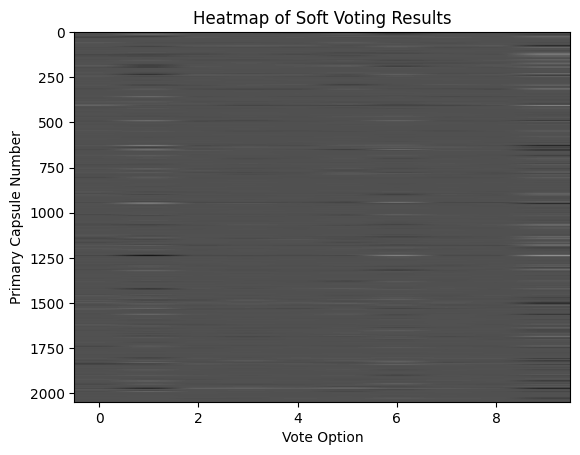

c_size is  torch.Size([100, 1, 2048, 1])


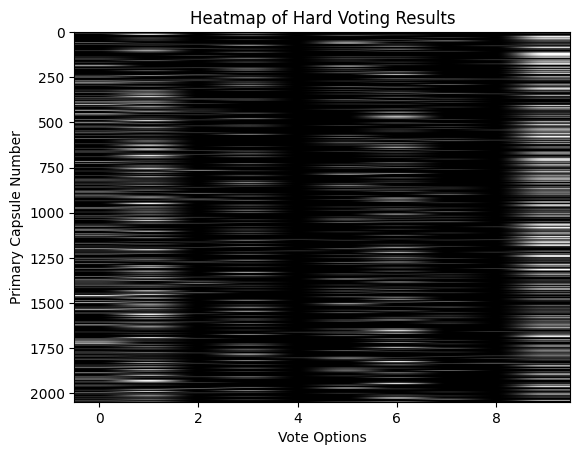

In [74]:
name1 = 'Soft_HeatMap_Noise_0.5.jpg'
name2 = 'Hard_HeatMap_Noise_0.5.jpg'
visualize_capsule_soft_and_hard(0.5, global_model, index_new, 100, name1, name2)
name1 = 'Soft_HeatMap_Noise_1.0.jpg'
name2 = 'Hard_HeatMap_Noise_1.0.jpg'
visualize_capsule_soft_and_hard(1.0, global_model, index_new, 100, name1, name2)
name1 = 'Soft_HeatMap_Noise_1.5.jpg'
name2 = 'Hard_HeatMap_Noise_1.5.jpg'
visualize_capsule_soft_and_hard(1.5, global_model, index_new, 100, name1, name2)
name1 = 'Soft_HeatMap_Noise_2.0.jpg'
name2 = 'Hard_HeatMap_Noise_2.0.jpg'
visualize_capsule_soft_and_hard(2.0, global_model, index_new, 100, name1, name2)

In [111]:
def visualize_c_soft(noise_scale, model, input, num_samples):
    image = images[input].unsqueeze(0)
    image_batch = image.repeat(num_samples, 1, 1, 1)
    noisy_images = add_gaussian_noise(noise_scale, image_batch)
    predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model(noisy_images)
    _, predicted_classes = predictions.max(1)
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    average_digit_caps_output = digit_caps_output.mean(dim=0, keepdim=True)
    print(c.size())
    c_2d = c.squeeze() 
    c_2d = c_2d.cpu()
    vote_avg_prob = c_2d.mean(dim=2)
    plt.figure(figsize=(10, 8))  
    plt.imshow(vote_avg_prob.cpu().numpy(), cmap='viridis', aspect='auto')
    plt.colorbar(label='Average Probability')
    plt.xlabel('Vote Option')
    plt.ylabel('Voting Round')
    plt.title('Heatmap of Voting Results based on Softmax Probabilities')
    plt.xticks(ticks=range(10), labels=range(10))  
    name = 'Soft_HeatMap_Noise.jpg'
    plt.savefig(name)
    plt.show()

In [100]:
def visualize_c(noise_scale, model, input, num_samples):
    image = images[input].unsqueeze(0)
    image_batch = image.repeat(num_samples, 1, 1, 1)
    noisy_images = add_gaussian_noise(noise_scale, image_batch)
    predictions, reconstruction, primary_caps_output, digit_caps_output, c, b = model.argmax_forward(noisy_images)
    _, predicted_classes = predictions.max(1)
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    average_digit_caps_output = digit_caps_output.mean(dim=0, keepdim=True)
    c_flat = c.view(-1)
    c_2d = c.squeeze() 
    c_2d = c_2d.cpu()
    vote_counts = torch.zeros((100, 10))
    for i in range(10):  
        vote_counts[:, i] = (c_2d == i).sum(dim=1)
    vote_ratios = vote_counts / 2048.0  
    plt.figure(figsize=(10, 8)) 
    plt.imshow(vote_ratios, cmap='viridis', aspect='auto')
    plt.colorbar(label='Vote Ratio')
    plt.xlabel('Vote Option')
    plt.ylabel('Voting Round')
    plt.title('Heatmap of Voting Results')
    plt.xticks(ticks=range(10), labels=range(10))  
    name = 'Hard_HeatMap_Noise.jpg'
    plt.savefig(name)
    plt.show()

In [101]:
index_new = 5 # 28 18 10 13 15 16 19 9 7 8

torch.Size([100, 10, 2048, 1])


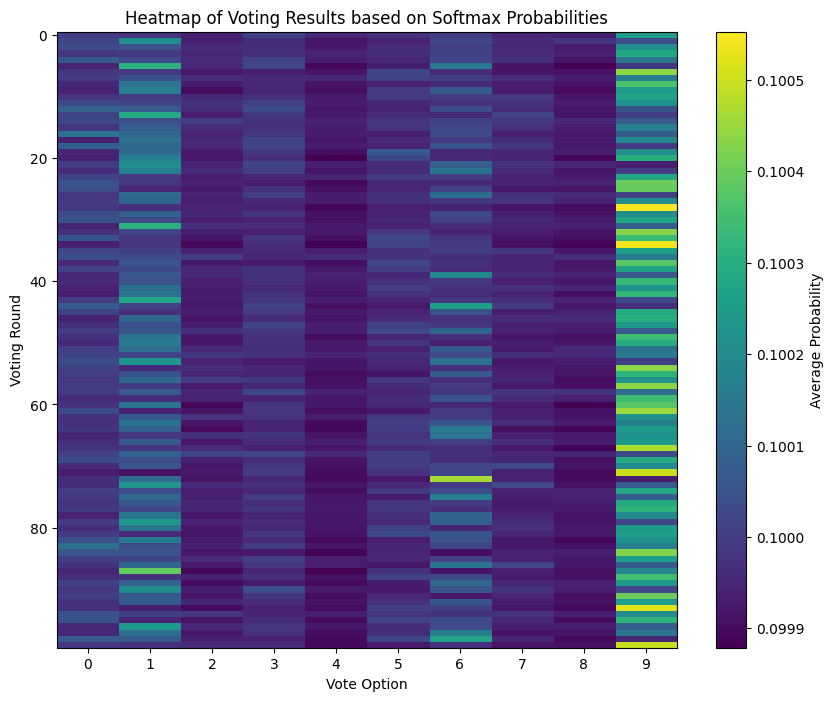

In [112]:
visualize_c_soft(2.0, global_model, index_new, 100)

--------------------
--------------------
The size of c is torch.Size([1, 10, 2048, 1])
The size of b is torch.Size([1, 10, 2048, 1])
c_max is tensor([[0.0998],
        [0.1008],
        [0.1014],
        ...,
        [0.1000],
        [0.1000],
        [0.1000]], device='cuda:1')


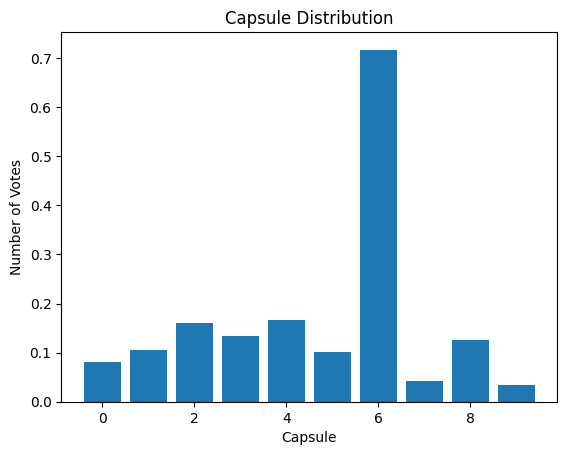

In [11]:
primary_caps_output_new, digit_caps_output_new, c_new, b_new = visual_images2(global_model, index_new)
visualize_digit_caps_output(digit_caps_output_new)

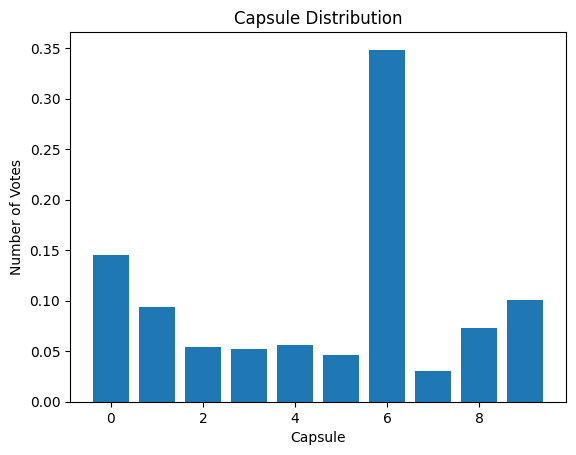

In [12]:
visualize_digit_caps_output_smoothing_softmax(0.5, global_model, index_new, 100)

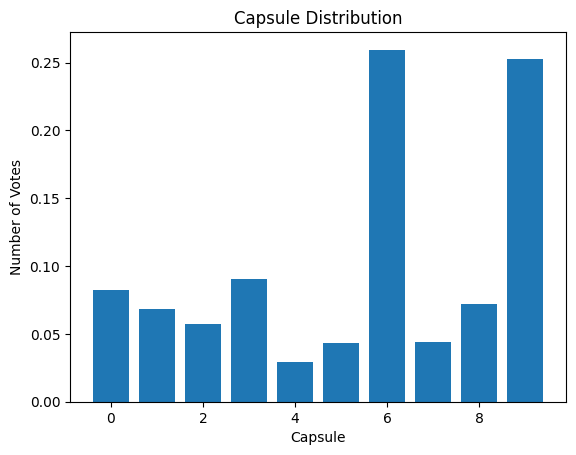

In [13]:
visualize_digit_caps_output_smoothing_softmax(1.0, global_model, index_new, 100)

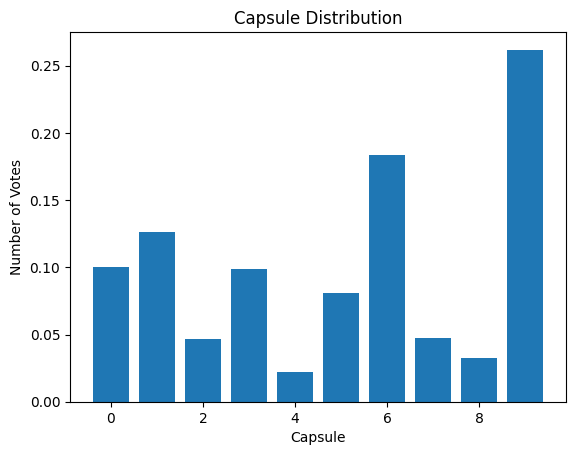

In [14]:
visualize_digit_caps_output_smoothing_softmax(1.5, global_model, index_new, 100)

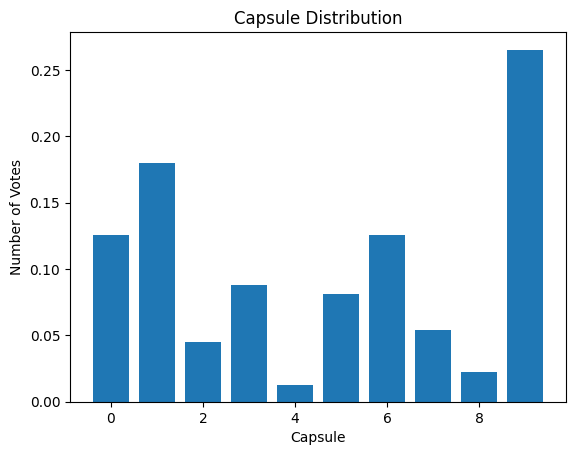

In [15]:
visualize_digit_caps_output_smoothing_softmax(2.0, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 2048, 1])


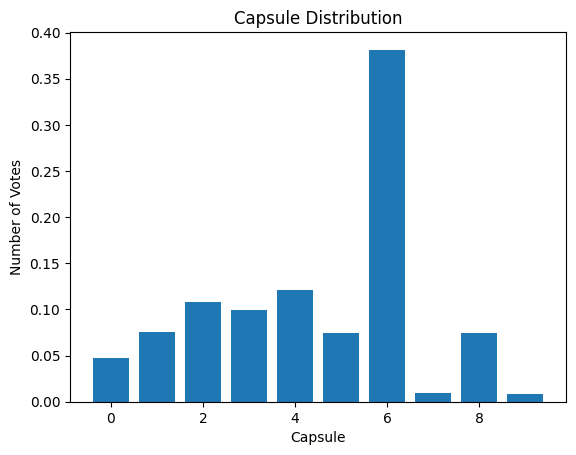

In [16]:
visualize_digit_caps_output_smoothing(0, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 2048, 1])


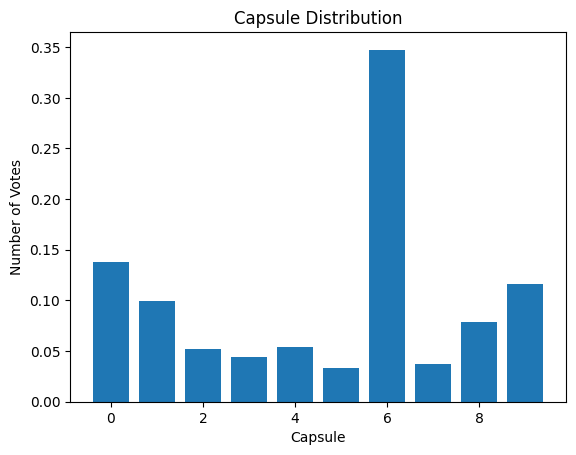

In [17]:
visualize_digit_caps_output_smoothing(0.5, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 2048, 1])


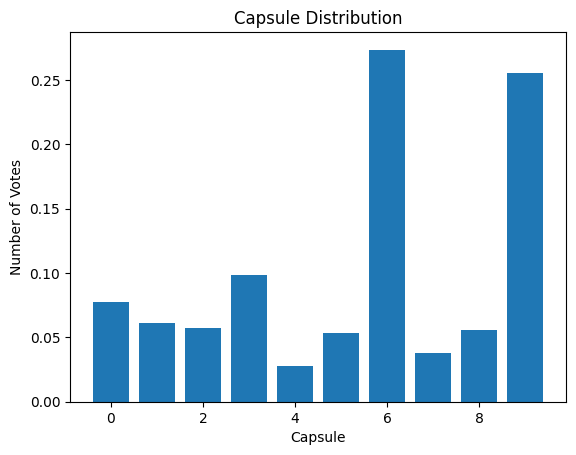

In [18]:
visualize_digit_caps_output_smoothing(1.0, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 2048, 1])


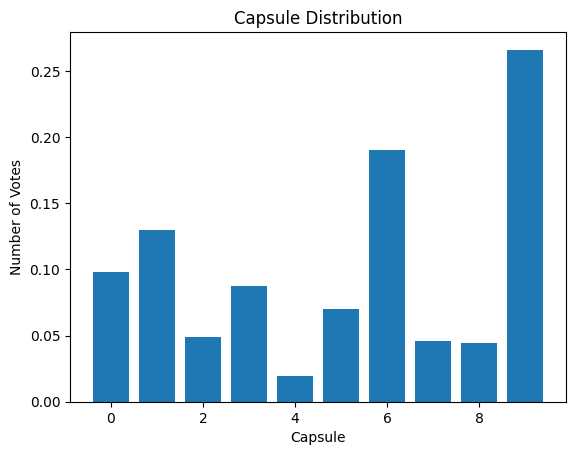

In [19]:
visualize_digit_caps_output_smoothing(1.5, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 2048, 1])


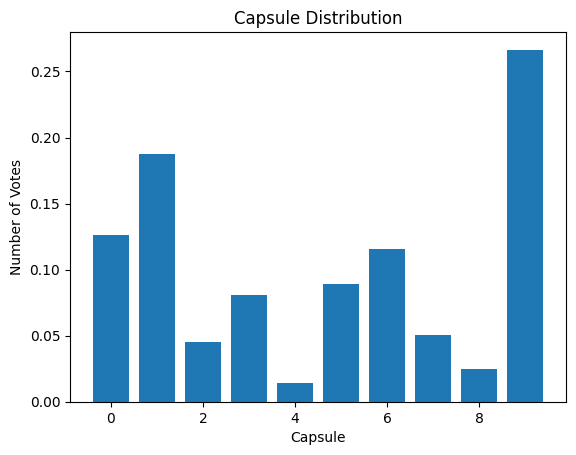

In [20]:
visualize_digit_caps_output_smoothing(2.0, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 2048, 1])


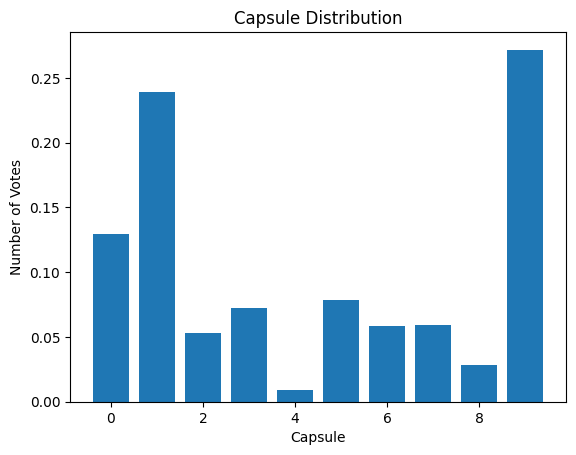

In [21]:
visualize_digit_caps_output_smoothing(3.0, global_model, index_new, 100)

In [ ]:
visualize_digit_caps_output_smoothing(2.5, global_model, index_new, 100)

c_size is  torch.Size([100, 1, 2048, 1])
